<a href="https://colab.research.google.com/github/vijayshankarrealdeal/GoogleColab/blob/main/TEXT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
# ! mkdir ~/.kaggle

In [98]:
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [99]:
# !kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

In [100]:
# !unzip "/content/train.csv.zip" -d "/content/d/"

In [101]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [102]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [103]:
# !wget 'http://nlp.stanford.edu/data/glove.6B.zip'

In [104]:
# !unzip "/content/glove.6B.zip" -d "/content/d/"

In [105]:
word2vec = {}

In [106]:
with open('/content/d/glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec

In [107]:
train = pd.read_csv("/content/d/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [108]:
def pre_process(sentences):
  tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
  tokenizer.fit_on_texts(sentences)
  sequences = tokenizer.texts_to_sequences(sentences)
  word2idx = tokenizer.word_index
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  return data,word2idx
data,word2idx = pre_process(sentences)

In [109]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [110]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [111]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [112]:
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/10
998/998 [==============================] - 15s 14ms/step - loss: 0.0835 - accuracy: 0.9804 - val_loss: 0.0699 - val_accuracy: 0.9937
Epoch 2/10
998/998 [==============================] - 13s 13ms/step - loss: 0.0677 - accuracy: 0.9892 - val_loss: 0.0783 - val_accuracy: 0.9938
Epoch 3/10
998/998 [==============================] - 13s 13ms/step - loss: 0.0631 - accuracy: 0.9917 - val_loss: 0.0684 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 13s 13ms/step - loss: 0.0598 - accuracy: 0.9927 - val_loss: 0.0676 - val_accuracy: 0.9933
Epoch 5/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0575 - accuracy: 0.9936 - val_loss: 0.0705 - val_accuracy: 0.9941
Epoch 6/10
998/998 [==============================] - 13s 13ms/step - loss: 0.0558 - accuracy: 0.9936 - val_loss: 0.0718 - val_accuracy: 0.9939
Epoch 7/10
998/998 [==============================] - 13s 13ms/step - loss: 0.0542 - accuracy: 0.9937 - val_loss: 0.0760 - val_accuracy:

[]

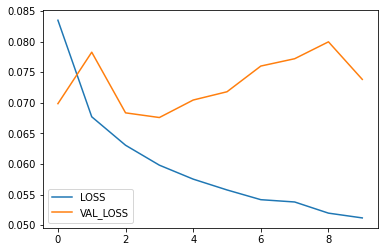

In [113]:
plt.plot(r.history['loss'],label = 'LOSS')
plt.plot(r.history['val_loss'],label = 'VAL_LOSS')
plt.legend()
plt.plot()

[]

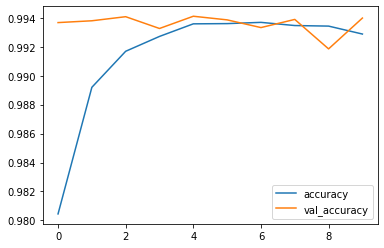

In [114]:
plt.plot(r.history['accuracy'],label = 'accuracy')
plt.plot(r.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
plt.plot()

In [115]:
# !unzip "/content/test.csv.zip" -d "/content/d/"

Archive:  /content/test.csv.zip
replace /content/d/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [171]:
#test_set
test = pd.read_csv("/content/d/test.csv")
ids = test.id
sentences_test = train["comment_text"].fillna("DUMMY_VALUE").values
data_test, word2idx_test = pre_process(sentences_test)

In [118]:
# !unzip "/content/test_labels.csv.zip" -d "/content/d/"

Archive:  /content/test_labels.csv.zip
replace /content/d/test_labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [119]:
test_labels = pd.read_csv('/content/d/test_labels.csv')
test_labels.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,-0.542530,-0.579895,-0.558193,-0.580913,-0.559916,-0.577642
std,0.572465,0.498408,0.542966,0.496195,0.539594,0.503260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [150]:
targets_test = test_labels.iloc[:,1:].values

In [160]:
predict = model.predict(data_test)

In [161]:
accs = []
for j in range(6):
  acu = roc_auc_score(targets[:,j],predict[:,j])
  accs.append(acu)
print(np.mean(accs)*100)

97.39901426653617


In [181]:
predict = predict[:153164,:]

In [183]:
id__ = pd.DataFrame(ids.values,columns = ['id'])

In [184]:
sub = pd.DataFrame(np.round(predict),columns=possible_labels)

In [189]:
finals = id__.join(sub)

In [190]:
finals

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.0,0.0,0.0,0.0,0.0,0.0
1,0000247867823ef7,0.0,0.0,0.0,0.0,0.0,0.0
2,00013b17ad220c46,0.0,0.0,0.0,0.0,0.0,0.0
3,00017563c3f7919a,0.0,0.0,0.0,0.0,0.0,0.0
4,00017695ad8997eb,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.0,0.0,0.0,0.0,0.0,0.0
153160,fffd7a9a6eb32c16,0.0,0.0,0.0,0.0,0.0,0.0
153161,fffda9e8d6fafa9e,0.0,0.0,0.0,0.0,0.0,0.0
153162,fffe8f1340a79fc2,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
finals.to_csv('submission.csv')

In [192]:
finals.shape

(153164, 7)